In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

stock_df = pd.read_csv('assignment_1b-data-1.csv')
ATBG = stock_df['ATBG']
BRDW = stock_df['BRDW']

In [2]:
# 准备数据，假设使用过去5天的数据来预测下一天的股票走势
window_size = 3
X_ATBG = np.array([ATBG[i:i+window_size] for i in range(len(ATBG)-window_size)] )
Y_ATBG = np.array( ATBG[window_size:] )
X_BRDW = np.array([BRDW[i:i+window_size] for i in range(len(BRDW)-window_size)] )
Y_BRDW = np.array( BRDW[window_size:] )

# transform data format to torch tensor 
X_ATBG_tensor = torch.tensor(X_ATBG, dtype=torch.float32)
Y_ATBG_tensor = torch.tensor(Y_ATBG, dtype=torch.float32)
X_BRDW_tensor = torch.tensor(X_BRDW, dtype=torch.float32)
Y_BRDW_tensor = torch.tensor(Y_BRDW, dtype=torch.float32)
X_ATBG_tensor.shape, Y_ATBG_tensor.shape

(torch.Size([97, 3]), torch.Size([97]))

In [ ]:
"""   model selection problem 

    def __init__(self, input_size):
        super(StockPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        outl1 = self.relu(self.fc1(x))
        outl2 = self.relu(self.fc2(outl1))
        outputs = self.fc3(outl2)
        return outputs
    
    """

In [3]:
# 定义神经网络模型
class StockPredictor(nn.Module):
    
    def __init__(self, input_size):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)  # 获取序列最后一个时间步的输出
        return out
    

# 初始化模型
input_size = window_size
model = StockPredictor(input_size)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
#ATBG_pred_bf = []
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(torch.unsqueeze(X_ATBG_tensor, dim=0))
    loss = criterion(outputs.view(-1), Y_ATBG_tensor)
    loss.backward()
    optimizer.step()
    #ATBG_pred_bf.append(outputs.detach().numpy())
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.9292
Epoch [200/1000], Loss: 0.2421
Epoch [300/1000], Loss: 0.0920
Epoch [400/1000], Loss: 0.0718
Epoch [500/1000], Loss: 0.0570
Epoch [600/1000], Loss: 0.0175
Epoch [700/1000], Loss: 0.0117
Epoch [800/1000], Loss: 0.0097
Epoch [900/1000], Loss: 0.0096
Epoch [1000/1000], Loss: 0.0093


In [4]:
# 使用训练好的模型进行预测
ATBG_pred_bf = model(torch.unsqueeze(X_ATBG_tensor, dim=0)).detach().numpy()


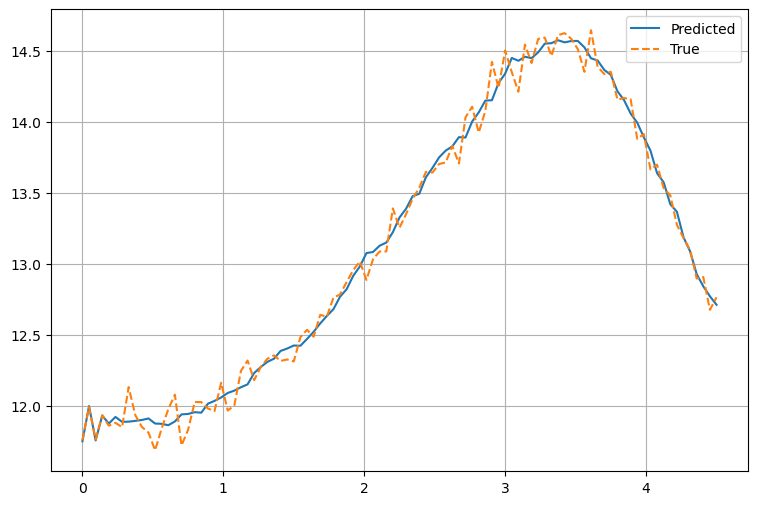

In [5]:
# 绘制预测结果
plt.figure(figsize=(9,6))
plt.plot(np.linspace(0,4.5,97),ATBG_pred_bf.reshape(97,1), label="Predicted")
plt.plot(np.linspace(0,4.5,97),Y_ATBG, label="True", linestyle='--')
plt.legend()
plt.grid()
plt.show()

torch.Size([1, 97, 3])

In [21]:
## predict future 4.5 months data
future_predictions = []

# 使用最后 window_size 天的数据作为初始输入
current_input = torch.tensor(X_ATBG[-1:], dtype=torch.float32)
current_input = current_input.unsqueeze( 0)
print(current_input.shape )

# predict future 45 days data iterately
for _ in range(45):
    with torch.no_grad():
        prediction = model(current_input).squeeze().item()
        #print(prediction)
    
    # 将预测值添加到未来预测列表中
    future_predictions.append(prediction)
    prediction = torch.tensor([[[prediction]]], dtype=torch.float32)
    # 更新当前输入，将新预测值加入 ( (current_input, new_data), dim=2)
    current_input = torch.cat((current_input[:,:,1:],prediction ) , dim =2 )
    #print(current_input[-2:])


torch.Size([1, 1, 3])


In [20]:
type(future_predictions), type(ATBG_pred_bf), prediction.shape , current_input.shape

(list, numpy.ndarray, torch.Size([1, 1, 1]), torch.Size([1, 1, 3]))

In [25]:
np.array(future_predictions).shape , ATBG_pred_bf.shape

((45,), (1, 97, 1))

In [26]:
future_predictions = np.array(future_predictions).reshape(45,1)
total = np.vstack((ATBG_pred_bf.reshape(97,1),future_predictions_arr.reshape(45,1)) )

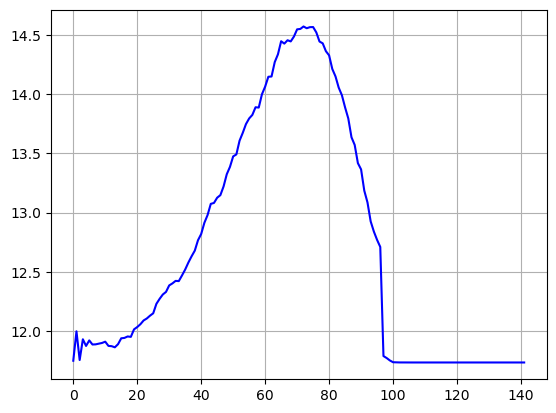

In [27]:
plt.plot(total[:], color='blue', label='previous 4.5 months')  # 绘制 arr2，前 10 行
#plt.plot(total[95:], color='red', label='future 4.5 months')   # 绘制 arr1，从第 11 行开始
plt.grid()


In [31]:
ATBG_pred_bf.reshape(97,1)[-1], future_predictions[:3]

(array([12.710161], dtype=float32),
 array([[11.78831768],
        [11.7714653 ],
        [11.75102139]]))